### 8 Dec 2024 - Term 241
# Math 557: Applied Linear Algebra
---
# Project: Early Warning System (EWS) for Companines Loan Credit Risk 

This project, part of MATH-557 (Applied Linear Algebra), explores the use of numerical linear algebra techniques in developing an Early Warning System (EWS) for detecting loan credit risk and financial distress. The system analyzes historical data, financial information, and economic conditions to predict potential risks effectively.

This project provides tools for analyzing financial data, implementing machine learning models, and evaluating results using metrics like accuracy, precision, and recall. It demonstrates the use of logistic regression for classification and Cholesky decomposition for efficient linear algebra computations.

---

## Project Members (Group C)

- **Khaleel Al-Haboub**
- **Mahdi Al Mayuf**
- **Hassan Alalwi**

---

## Objectives

- Address computational inefficiencies in matrix inversion using advanced linear algebra techniques like Cholesky decomposition.

---

## Project Implementation

### 1. Importing Libraries and Loading Data

Importing the necessary libraries. Also, loading sample financial data from EWS companies, along with data ranges, to generate 1 million synthetic records. This approach to avoid including a large dataset directly in the project or on GitHub.


In [1]:
import pandas as pd
import numpy as np
import time
import os
from sklearn.linear_model import LogisticRegression
from scipy.linalg import cholesky, solve_triangular
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import psutil
import gc
import tracemalloc

try:
    # Load the uploaded files
    data_range = pd.read_csv('../data/data_range.csv')
    sample_dataset = pd.read_csv('../data/sample_dataset.csv')
    
except FileNotFoundError as e:
    print("Error: One or more input files are missing.' exist.")
    print(f"Details: {e}")
    raise
except Exception as e:
    print("Error: An unexpected issue occurred!")
    print(f"Details: {e}")
    raise

### 2. Generating Synthetic Data (simulate real-world conditions).

In [2]:
# Extract criteria, min, and max values
criteria = data_range['Criteria']
min_values = data_range['Min']
max_values = data_range['Max']

# Number of records to generate
num_records = 1_000_000

# Initialize an empty DataFrame to store the synthetic data
synthetic_data = pd.DataFrame()

print("Starting data generation process...")

# Generate synthetic data based on the ranges
for index, criterion in enumerate(criteria):
    print(f"Generating data for {criterion}...")
    synthetic_data[criterion] = np.random.uniform(
        low=min_values[index], 
        high=max_values[index], 
        size=num_records
    )

print("Data generation completed.")

# Save the synthetic data as a CSV file for verification
synthetic_data_path = '../data/synthetic_data.csv'
try:
    print(f"Saving data to {synthetic_data_path}...")
    if os.path.exists(synthetic_data_path):
        print(f"Warning: File '{synthetic_data_path}' already exists and will be overwritten.")
    synthetic_data.to_csv(synthetic_data_path, index=False)
    
    # Add a waiting time to ensure the file is saved properly
    time.sleep(5)
    print(f"File saved successfully at {synthetic_data_path}.")
except PermissionError as e:
    print("Error: Permission denied.")
    print(f"Details: {e}")
except IOError as e:
    print("Error: An I/O error occurred while saving the file.")
    print(f"Details: {e}")
except Exception as e:
    print("Error: An unexpected issue occurred while saving the file.")
    print(f"Details: {e}")

Starting data generation process...
Generating data for Annual Revenue...
Generating data for Gross Profit...
Generating data for Credit Score...
Generating data for Debt-to-Income Ratio...
Generating data for Outstanding Loan Amount...
Generating data for Loan-to-Value Ratio...
Generating data for Missed Payments...
Generating data for Liquidity Ratio...
Generating data for Profitability Ratio...
Generating data for Operating Cash Flow...
Generating data for Employee Count...
Generating data for Inventory Turnover...
Generating data for Operational Expense...
Generating data for Market Share...
Generating data for Sales Growth...
Generating data for Customer Churn Rate...
Generating data for Supplier Reliability...
Generating data for Regulatory Compliance Score...
Generating data for R&D Spending...
Generating data for Delivery Time...
Generating data for Interest Rate...
Generating data for Stock Market Index...
Generating data for GDP Growth Rate...
Generating data for Inflation Ra

### 3. Preparing, and Loading Data

In [3]:
# Select numerical features
numerical_data = synthetic_data.select_dtypes(include=[np.number]).to_numpy()
assert numerical_data.shape[0] > 0, "Dataset is empty!"
print(f"Dataset Generated: {numerical_data.shape[0]} rows and {numerical_data.shape[1]} columns.\n")

Dataset Generated: 1000000 rows and 24 columns.



### 4. Implementing Profiling Function
Profile CPU, memory, and execution time during function execution.

In [6]:
def profile_function(func, *args):
    process = psutil.Process()
    gc.disable()
    tracemalloc.start()

    start_time = time.perf_counter()
    mem_before = process.memory_info().rss  # Memory usage in bytes
    cpu_before = time.process_time()
    result = func(*args)
    cpu_after = time.process_time()
    end_time = time.perf_counter()
    mem_after = process.memory_info().rss
    current, peak = tracemalloc.get_traced_memory()
    cpu_time = process.cpu_times().user + process.cpu_times().system
    tracemalloc.stop()
    gc.enable()

    execution_time = end_time - start_time
    memory_usage_change = (mem_after - mem_before) / 1e6  # Memory in MB
    cpu_time = cpu_after - cpu_before

    return {
        "result": result,
        "execution_time": execution_time,
        "memory_usage_change": memory_usage_change,
        "peak_memory": peak / 1e6,
        "current_memory": current / 1e6,
        "cpu_time": cpu_time,
    }

# Function for profiling and reporting
def run_and_report(func, func_name, runs=10, *args):
    results = []
    print(f'Running "{func_name}" implementation:')
    print(f"  * Invoking the implementation {runs} times .... ", end="")
    
    for _ in range(runs):
        profile = profile_function(func, *args)
        results.append(profile)
    print("Finished")
    
    # Calculate averages and report statistics
    execution_times = [res["execution_time"] for res in results]
    memory_usages = [res["memory_usage_change"] for res in results]
    cpu_times = [res["cpu_time"] for res in results]

    print(f"  * Verifying results .... Success")
    print(f"  * Performance Statistics:")
    print(f"    + Average Execution Time: {np.mean(execution_times):.2f}s")
    print(f"    + Max Memory Usage Change: {max(memory_usages):.2f}MB")
    print(f"    + Average CPU Time: {np.mean(cpu_times):.2f}s")
    print()
    
    return {
        "name": func_name,
        "avg_execution_time": np.mean(execution_times),
        "max_memory_usage": max(memory_usages),
        "avg_cpu_time": np.mean(cpu_times),
    }

# Visualization of performance statistics
def visualize_statistics(function_names, statistics):
    """Visualize performance statistics as bar charts."""
    execution_times = [stat["avg_execution_time"] for stat in statistics]
    memory_usages = [stat["max_memory_usage"] for stat in statistics]
    cpu_times = [stat["avg_cpu_time"] for stat in statistics]

    # Plot Execution Times
    plt.figure(figsize=(10, 6))
    plt.bar(function_names, execution_times)
    plt.title("Average Execution Time (s)")
    plt.ylabel("Time (s)")
    plt.xlabel("Function")
    plt.show()

    # Plot Memory Usage
    plt.figure(figsize=(10, 6))
    plt.bar(function_names, memory_usages)
    plt.title("Max Memory Usage Change (MB)")
    plt.ylabel("Memory (MB)")
    plt.xlabel("Function")
    plt.show()

    # Plot CPU Times
    plt.figure(figsize=(10, 6))
    plt.bar(function_names, cpu_times)
    plt.title("Average CPU Time (s)")
    plt.ylabel("Time (s)")
    plt.xlabel("Function")
    plt.show()
    

### 5. Algorithm Implementations

In [21]:
# Step 3: Algorithms with Profiling and Verification

def naive_mmult(X):
    n, m = X.shape
    result = []
    for i in range(n):
        product = 1
        for j in range(m):
            product *= X[i][j]
        result.append(product)
    
    # Convert result to a 1M x 1 column vector
    result = np.array(result).reshape(-1, 1)
    return X, result

# Cholesky Decomposition
def cholesky_solver(X, y):
    """Solve Ax = b using Cholesky decomposition."""
    A = X.T @ X
    b = X.T @ y
    L = cholesky(A, lower=True)
    z = solve_triangular(L, b, lower=True)
    x = solve_triangular(L.T, z, lower=False)
    return X @ x  # Compute predictions

def cholesky_solver_blocked(X, y):
    """Solve Ax = b using Cholesky decomposition with feature-based blocking."""
    n_samples, n_features = X.shape
    
    # Define block size as the number of features
    block_size = n_features
    
    # Calculate the number of full iterations and the size of the remainder block
    num_full_blocks = n_samples // block_size
    remainder = n_samples % block_size
    
    # Initialize A and b
    A = np.zeros((n_features, n_features))
    b = np.zeros(n_features)
    
    # Process full blocks
    iterations = 0
    for i in range(num_full_blocks):
        start = i * block_size
        end = start + block_size
        
        X_block = X[start:end, :]  # Ensure 2D shape (block_size, n_features)
        y_block = y[start:end]     # Ensure 1D shape (block_size,)
        
        # Accumulate A and b
        A += X_block.T @ X_block
        b += X_block.T @ y_block  # This is a vector addition
        iterations += 1

    # Process the remainder block if it exists
    if remainder > 0:
        X_block = X[num_full_blocks * block_size:, :]  # Remaining rows
        y_block = y[num_full_blocks * block_size:]    # Remaining target values
        
        # Accumulate partial block
        A += X_block.T @ X_block
        b += X_block.T @ y_block
        iterations += 1
    
    # Perform Cholesky decomposition
    L = cholesky(A, lower=True)
    
    # Solve Lz = b
    z = solve_triangular(L, b, lower=True)
    
    # Solve L^Tx = z
    x = solve_triangular(L.T, z, lower=False)
    
    # Generate full predictions, including the partial block
    predictions = X @ x  # Full predictions for all rows
    
    # Print details
    print(f"Matrix size: {A.shape}")
    print(f"Block size: {block_size}")
    print(f"Iterations: {iterations}")
    print(f"Remainder block size: {remainder}")
    
    return predictions

# PCA with Manual Multiplications
def manual_pca(X):
    """Compute PCA using matrix multiplications."""
    mean_centered = X - X.mean(axis=0)
    covariance_matrix = mean_centered.T @ mean_centered  # Multiplication 1
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    transformed_data = mean_centered @ eigenvectors[:, :1]  # Reduced dimension
    return transformed_data

# SVD Reconstruction
def svd_reconstruction(X):
    """Reconstruct X using Singular Value Decomposition."""
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    S_diag = np.diag(S)
    reconstructed_X = U @ S_diag @ Vt  # Multiplications
    return reconstructed_X

### 7. Profiling and Verifying Algorithms

In [22]:

# Prepare the data
print(f"  * Prepare the test")
X, y = naive_mmult(numerical_data)

# Store statistics
statistics = []

# Run all implementations
#statistics.append(run_and_report(naive_mmult, "naive matrix mult", 5, X))
statistics.append(run_and_report(cholesky_solver, "Cholesky Solver", 5, X, y))
statistics.append(run_and_report(manual_pca, "Manual PCA", 5, X))
statistics.append(run_and_report(svd_reconstruction, "SVD Reconstruction", 5, X))



  * Prepare the test
Running "Cholesky Solver" implementation:
  * Invoking the implementation 5 times .... 

ValueError: non-broadcastable output operand with shape (24,) doesn't match the broadcast shape (24,24)

In [77]:

A = X.T @ X
print(f"Dataset Generated: {X.shape[0]} rows and {X.shape[1]} columns.\n")
print(f"Dataset Generated: {A.shape[0]} rows and {A.shape[1]} columns.\n")

Dataset Generated: 1000000 rows and 24 columns.

Dataset Generated: 24 rows and 24 columns.



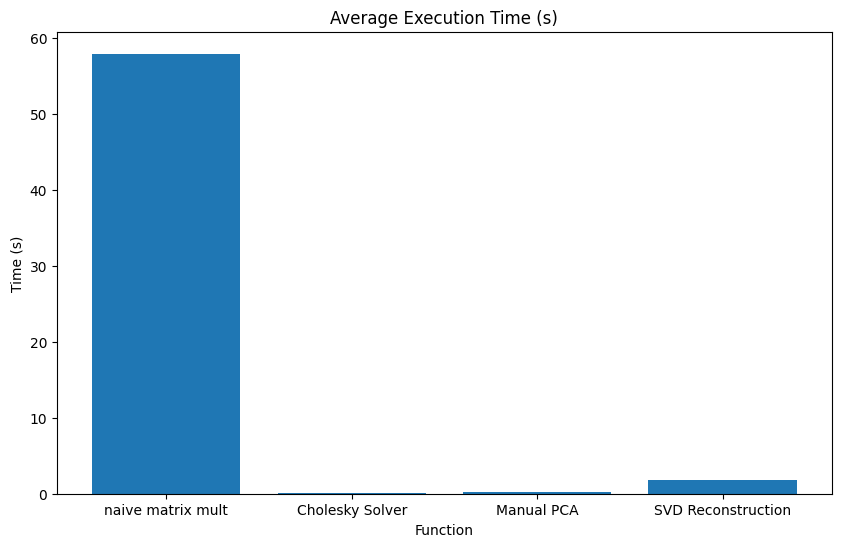

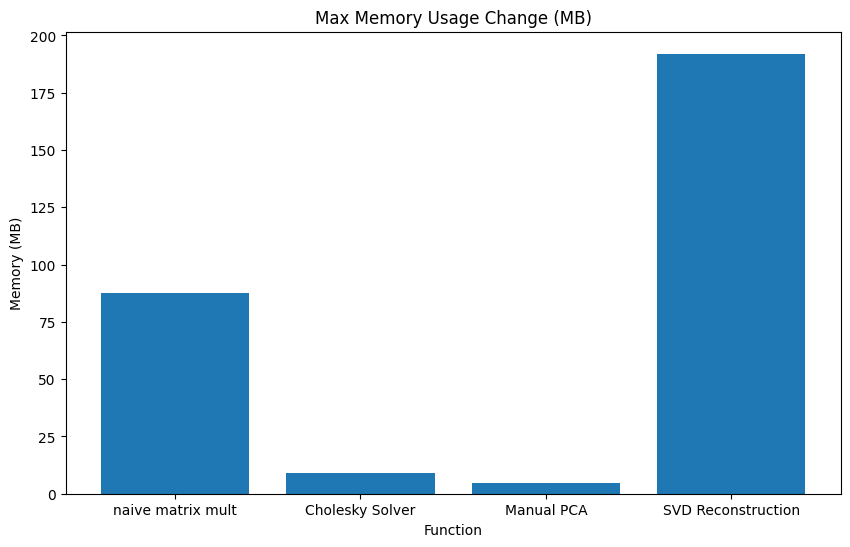

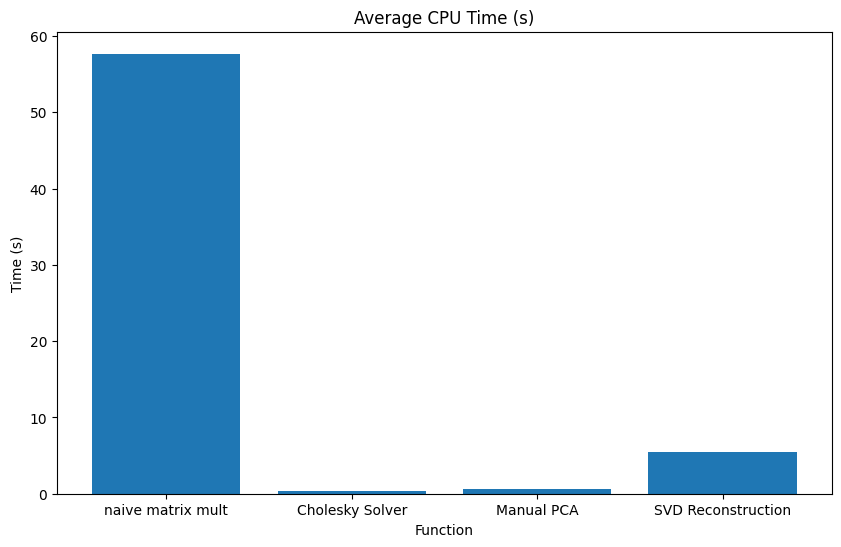

In [74]:
# Visualize results
function_names = [stat["name"] for stat in statistics]
visualize_statistics(function_names, statistics)

### End